# Embedded ML Lab - Challenge (testing yolo example)

This is an example of inference with the VOC data set and tinyyolov2. There are pretrained weights (`voc_pretrained.pt`) stored that can be loaded into the model.

In [1]:
%cd ..

/home/jetson/embedded-ml-lab-students-ss24/emb-ml-challenge


In [2]:
import torch
import tqdm
from utils.dataloader import VOCDataLoaderPerson, VOCDataLoader
from utils.tinyyolov2 import TinyYoloV2
from utils.yolo import nms, filter_boxes
from utils.viz import display_result
from torchinfo import summary
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision

import onnx
import onnxruntime as ort

ort.get_device()

'GPU'

In [3]:
def reduce_classes(weight, keep_classes, classes_count, anchor_count):
    finished_anchors = []
    
    for k in range(anchor_count):
        anchor_length = 5 + classes_count
        anchor = weight[k * anchor_length:(k + 1) * anchor_length]
        anchor_details = anchor[0:5]
        classes_kernel = anchor[5:]
        
        keep_mask = torch.nn.functional.one_hot(torch.Tensor(keep_classes).long(), classes_count)[0].bool()
        remove_mask = ~keep_mask
    
        kernels_combined = classes_kernel[remove_mask].sum(0, keepdim=True) / (classes_count - len(keep_classes))
    
        finished_anchors.append(anchor_details)
        finished_anchors.append(classes_kernel[keep_mask])
        finished_anchors.append(kernels_combined)
        
    return torch.cat(finished_anchors)

#state_dict = torch.load("runs/voc_pretrained.pt")
#state_dict['conv9.weight'] = reduce_classes(state_dict['conv9.weight'], [14], 20, 5)
#state_dict['conv9.bias'] = reduce_classes(state_dict['conv9.bias'], [14], 20, 5)

loader = VOCDataLoaderPerson(train=False, batch_size=1)

# make an instance with 1 class as output
#net = TinyYoloV2(num_classes=20)
#net.load_state_dict(state_dict)
#net.eval()

#torch.onnx.export(net, torch.zeros(1, 3, 320, 320), "runs/voc_person_only.onnx", input_names = ['input'], output_names = ['output'])
#print(summary(net, input_size=(1, 3, 320, 320), col_names = ("mult_adds", "input_size", "kernel_size", "num_params")))

test_size = len(loader) / 4

#print('Preload images')
#test_data = []
#for idx, (input, target) in tqdm.tqdm(enumerate(loader), total=test_size):
#    test_data.append([idx, input, target])
#    if idx >= test_size:
#        break

In [4]:
import torchvision

def apply_bboxes(image, output):
    img_shape = 320

    cv2.putText(image, "fps=30", (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 0), 2, cv2.LINE_AA)
    
    bboxes = torch.stack(output, dim=0)
    
    for i in range(bboxes.shape[1]):

        # only show person
        # if int(bboxes[0,i,5]) != 14:
        #    continue
        
        if bboxes[0,i,-1] >= 0:
            
            cx = int(bboxes[0,i,0]*img_shape - bboxes[0,i,2]*img_shape/2)
            cy = int(bboxes[0,i,1]*img_shape - bboxes[0,i,3]*img_shape/2)

            w = int(bboxes[0,i,2]*img_shape)
            h = int(bboxes[0,i,3]*img_shape)
            
            cv2.rectangle(image, (cx, cy), (cx + w, cy + h), color=(255,0,0), thickness=2)

            # annotation = num_to_class(int(bboxes[0,i,5])) + " "+  f"{float(bboxes[0,i,4]):.2f}"
            annotation = f"person {float(bboxes[0,i,4]):.2f}"
            
            cv2.putText(image, annotation, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 0), 2, cv2.LINE_AA)
            
    return image

# original source https://github.com/ultralytics/yolov5/blob/master/utils/general.py
# adapted from https://github.com/eriklindernoren/PyTorch-YOLOv3/blob/master/pytorchyolo/utils/utils.py

def xyxy2xywh(x):
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = (x[..., 0] + x[..., 2]) / 2  # x center
    y[..., 1] = (x[..., 1] + x[..., 3]) / 2  # y center
    y[..., 2] = x[..., 2] - x[..., 0]  # width
    y[..., 3] = x[..., 3] - x[..., 1]  # height
    return y

def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None):
    """Performs Non-Maximum Suppression (NMS) on inference results
    Returns:
         detections with shape: nx6 (x1, y1, x2, y2, conf, cls)
    """

    nc = prediction.shape[2] - 5  # number of classes

    # Settings
    # (pixels) minimum and maximum box width and height
    max_wh = 4096
    max_det = 300  # maximum number of detections per image
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    multi_label = nc > 1  # multiple labels per box (adds 0.5ms/img)

    output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    classes_tensor = torch.tensor(classes, device=prediction.device) if classes is not None else None

    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[x[..., 4] > conf_thres]  # confidence

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes_tensor is not None:
            x = x[(x[:, 5:6] == classes_tensor).any(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            # sort by confidence
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]

        # Batched NMS
        c = x[:, 5:6] * max_wh  # classes
        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]

        output[xi] = xyxy2xywh(x[i])

    return output


In [5]:
# only check model, not strictly required
onnx_model = onnx.load("runs/voc_person_only.onnx")
onnx.checker.check_model(onnx_model)

session = ort.InferenceSession('runs/voc_person_only.onnx', providers=['CUDAExecutionProvider'])
binding = session.io_binding()

device_name = 'cpu'
output_orig = torch.empty((1, 5, 10, 10, 5 + 20), dtype=torch.float32, device=torch.device(device_name))
binding.bind_output(
    name = 'output',
    device_type = device_name,
    device_id = 0,
    element_type = np.float32,
    shape = output_orig.shape,
    buffer_ptr = output_orig.data_ptr()
)

print(session.get_providers())

measured_inference = []
measured_filter_boxes = []
measured_apply_bboxes = []
measured_total = []

test_new_code = True

for idx, (input, target) in tqdm.tqdm(enumerate(loader), total=test_size):
    # input is 1 x 3 x 320 x 320
    s1 = time.time()

    binding.bind_input(
        name = 'input',
        device_type = device_name,
        device_id = 0,
        element_type = np.float32,
        shape = input.shape,
        buffer_ptr = input.data_ptr()
    )
    session.run_with_iobinding(binding)
    
    e1 = time.time()
    measured_inference.append(e1 - s1)
    

    s2 = time.time()

    #filter boxes based on confidence score (class_score*confidence) and overlap
    if test_new_code:
        output = non_max_suppression(output_orig, 0.1, 0.25)
    else:
        output = nms(filter_boxes(output_orig, 0.1), 0.25)
    
    e2 = time.time()
    measured_filter_boxes.append(e2 - s2)
    
    s3 = time.time()

    result = apply_bboxes(input[0].numpy().transpose((1, 2, 0)).copy(), output)
    
    e3 = time.time()
    measured_apply_bboxes.append(e3 - s3)

    measured_total.append(e3 - s1)
    
    #display_result(input, output, target)
    #plt.imshow(result, interpolation='nearest')
    #plt.show()

    if idx >= test_size:
            break

['CUDAExecutionProvider', 'CPUExecutionProvider']


  0%|          | 1/558.0 [00:32<4:59:07, 32.22s/it]


RuntimeError: Couldn't load custom C++ ops. This can happen if your PyTorch and torchvision versions are incompatible, or if you had errors while compiling torchvision from source. For further information on the compatible versions, check https://github.com/pytorch/vision#installation for the compatibility matrix. Please check your PyTorch version with torch.__version__ and your torchvision version with torchvision.__version__ and verify if they are compatible, and if not please reinstall torchvision so that it matches your PyTorch install.

In [6]:
# !pip uninstall torchvision -y
# !pip install torchvision==0.9.1 --index-url=https://download.pytorch.org/whl
# !pip show torchvision
torch.__version__, torchvision.__version__

('1.8.1a0+56b43f4', '0.9.1')

0.07283743421592098


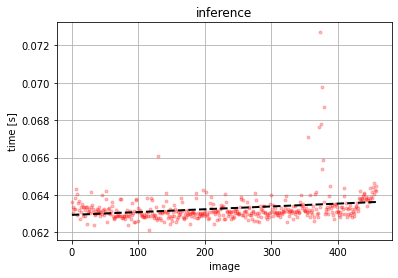

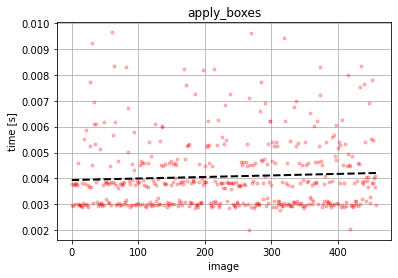

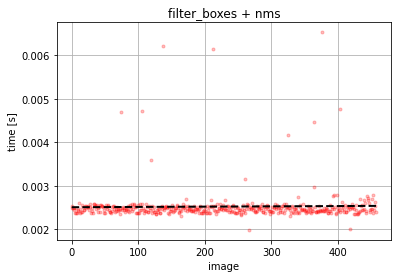

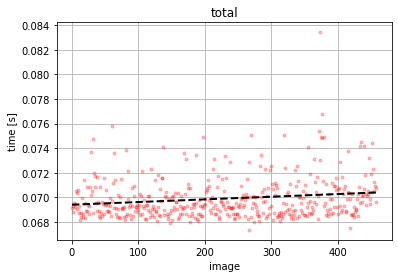

In [10]:
def plot_measurement(y, title):
    y = y[100:]
    x = np.arange(y.shape[0])
    plt.figure()
    plt.title(title)
    plt.plot(x, y, 'r.', alpha=0.25)
    plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), '--k', linewidth=2)
    plt.xlabel('image')
    plt.ylabel('time [s]')
    plt.grid()
    plt.show()

print(sum(measured_total) / len(measured_total))

plot_measurement(np.array(measured_inference), 'inference')
plot_measurement(np.array(measured_apply_bboxes), 'apply_boxes')
plot_measurement(np.array(measured_filter_boxes), 'filter_boxes + nms')
plot_measurement(np.array(measured_total), 'total')